## Установка зависимостей

In [1]:
%pip install -r /kaggle/input/word-cloud-dataset/requirements.txt -q
%pip install natasha -q

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import nltk
nltk.download('brown')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /usr/share/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize
import json
from natasha import MorphVocab, Doc, Segmenter, NewsMorphTagger, NewsEmbedding
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

### Считываение датасета и объединение всех ответов в один массив

In [4]:
def dataset_to_text(dataset_path: str):
    with open(dataset_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    texts = []
    for answer in data["answers"]:
        texts.extend(answer)
    return texts

In [5]:
DATASET_PATH = '/kaggle/input/word-cloud-dataset/big_dataset_1000.json'
texts = dataset_to_text(DATASET_PATH)

### Приведение к нижнему регистру

In [6]:
def to_lowercase(sentence: str) -> str:
    return sentence.lower()

In [7]:
texts = list(map(to_lowercase, texts))

### Лемматизация и удаление стоп-слов

In [8]:
def remove_stopwords(sentence: str) -> str:
    # Получаем список стоп-слов для русского и английского языков
    stop_words_russian = set(stopwords.words('russian'))
    stop_words_english = set(stopwords.words('english'))
    
    # Объединяем два набора стоп-слов
    stop_words = stop_words_russian.union(stop_words_english)
    
    # Токенизируем предложение
    words = word_tokenize(sentence)
    
    # Фильтруем предложение, удаляя стоп-слова
    filtered_sentence = [word for word in words if word.lower() not in stop_words]
    
    return ' '.join(filtered_sentence)

In [9]:
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

def lemmatize(sentence: str) -> str:
    lemmatized = ''
    doc = Doc(sentence)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
        #print(token.text, token.lemma)
        lemmatized += token.lemma + ' '
    return lemmatized.strip()

In [10]:
lemmatized_texts = []
lemmatize_dict = {}

for sentence in texts:
    lemmatized_sentence = lemmatize(remove_stopwords(sentence))
    lemmatize_dict[lemmatized_sentence] = sentence
    lemmatized_texts.append(lemmatized_sentence)
    
lemmatized_texts = list(map(remove_stopwords, lemmatized_texts))

In [11]:
def count_words_phrases(lemmatized_texts):
    word_count = Counter(lemmatized_texts)
    return dict(word_count)

word_freq_dict = count_words_phrases(lemmatized_texts)

### Получение эмбеддингов 

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

tokenizer = AutoTokenizer.from_pretrained("ai-forever/ru-en-RoSBERTa")
model = AutoModel.from_pretrained("ai-forever/ru-en-RoSBERTa").to(device)

def get_word_embedding(word: str):
    inputs = tokenizer("clustering: " + word, return_tensors="pt", max_length=512, padding=True, truncation=True).to(device)  # Перемещаем входные данные на GPU
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0]

# Нормализация эмбеддингов
def normalize_embeddings(embedding):
    return F.normalize(embedding, p=2, dim=1)

def get_sentence_embedding(sentence: str):
    sentence_vector = normalize_embeddings(get_word_embedding(sentence)).cpu().numpy().reshape(-1)
    return sentence_vector

Используемое устройство: cuda


tokenizer_config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.49M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/5.99M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/715 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.61G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
embeddings = []
for sentence in tqdm(word_freq_dict.keys()):
    embeddings.append(get_sentence_embedding(sentence))

embeddings = np.array(embeddings)

100%|██████████| 814/814 [00:17<00:00, 47.15it/s]


### Кластеризация

In [14]:
agglomerative = AgglomerativeClustering(n_clusters=None, distance_threshold=1.5, linkage='ward')
labels = agglomerative.fit_predict(embeddings)

# dbscan = DBSCAN(eps=0.8, min_samples=1)
# labels = dbscan.fit_predict(embeddings)

word_clusters = defaultdict(list)
for word, label in zip(word_freq_dict.keys(), labels):
    word_clusters[label].append(word)

# Вывод кластеров
print("Кластеры слов:")
for label, cluster_words in word_clusters.items():
    print(f"Кластер {label}: {', '.join(cluster_words)}")

Кластеры слов:
Кластер 51: ответственность, личный ответственность, умение брать ответственность, социальный ответственность, ответственный, нести ответственность, ответственность результат
Кластер 31: пунктуальность, аккуратность, дисциплина, жесткий дисциплина, скрупулезность, деловитость, дисциплинированный, пунктуальный, дисциплинированность
Кластер 2: решительность, упорство, настойчивость, сила воля, смелость, умение убеждать, решимость, бескомпромиссность, умение защищать свой интерес, упертость, умение держать удар, убедительный, упорный, убеждать, принципиальность, умение отстаивать свой граница, убедительность, умение отстаивать точка зрение
Кластер 5: инициативность, харизма, креативность, инициатива, умение импровизировать, инновационность, креатив, креативный мышление, творческий мышление, позитивный мышление, творческий подход, организаторский способность, свежий идея, креативный подход, научный подход, перспективный мышление, инновационный идея, разнообразный подход, пер

In [15]:
# Подсчет частоты слов в Brown Corpus (для сравнительной частоты в языке)
brown_freq = Counter(brown.words())

def lemma_replacement(lemma: str) -> str:
    if lemma in lemmatize_dict.keys():
        return lemmatize_dict[lemma]
    return lemma

# Функция для выбора самого частого слова в кластере
def select_most_frequent_word(cluster_words, word_freq_dict):
    """
    Выбирает самое популярное слово в кластере, исходя из частоты встречаемости
    в текущем словаре word_freq_dict. При равной частоте использует частоту в языке (brown_freq).
    """
    # Сортировка слов по частоте встречаемости в словаре, а при равенстве — по частоте в языке
    sorted_words = sorted(
        cluster_words,
        key=lambda word: (-word_freq_dict[word], -brown_freq.get(word, 0))
    )
    return sorted_words[0]  # Возвращаем наиболее популярное слово

# Формируем итоговый словарь: ключ — наиболее частое слово, значение — сумма встречаемости слов в кластере
def form_final_word_dict(word_clusters, word_freq_dict):
    final_word_dict = {}
    
    for label, cluster_words in word_clusters.items():
        # Выбираем самое частое слово в кластере
        most_frequent_word = select_most_frequent_word(cluster_words, word_freq_dict)
        
        # Суммируем частоты встречаемости всех слов в кластере
        cluster_word_count_sum = sum(word_freq_dict[word] for word in cluster_words)
        
        # Добавляем в итоговый словарь: ключ — самое частое слово, значение — сумма частот всех слов в кластере
        final_word_dict[most_frequent_word] = cluster_word_count_sum
    
    return final_word_dict

# Формируем итоговый словарь
final_word_dict = form_final_word_dict(word_clusters, word_freq_dict)

def lemma_replacement(lemma: str) -> str:
    if lemma in lemmatize_dict.keys():
        return lemmatize_dict[lemma]
    return lemma

def replace_keys_by_function(d, func):
    return {func(k): v for k, v in d.items()}
final_word_dict = replace_keys_by_function(final_word_dict, lemma_replacement)

# Вывод результата
print("Итоговый словарь с частотами слов в кластерах:")
for word, count in final_word_dict.items():
    print(f"Слово: {word}, Сумма встречаемости в кластере: {count}")

Итоговый словарь с частотами слов в кластерах:
Слово: ответственность, Сумма встречаемости в кластере: 130
Слово: пунктуальность, Сумма встречаемости в кластере: 105
Слово: упорство, Сумма встречаемости в кластере: 202
Слово: инициативность, Сумма встречаемости в кластере: 302
Слово: стрессоустойчивость, Сумма встречаемости в кластере: 274
Слово: гибкость, Сумма встречаемости в кластере: 136
Слово: работа, Сумма встречаемости в кластере: 96
Слово: работать на результат, Сумма встречаемости в кластере: 42
Слово: внимательность, Сумма встречаемости в кластере: 56
Слово: коммуникабельность, Сумма встречаемости в кластере: 134
Слово: целеустремленность, Сумма встречаемости в кластере: 199
Слово: быстрый, Сумма встречаемости в кластере: 77
Слово: результативный, Сумма встречаемости в кластере: 222
Слово: смекалка, Сумма встречаемости в кластере: 60
Слово: организованный, Сумма встречаемости в кластере: 189
Слово: критическое мышление, Сумма встречаемости в кластере: 85
Слово: обучаемый, Сум

### Построение облака слов

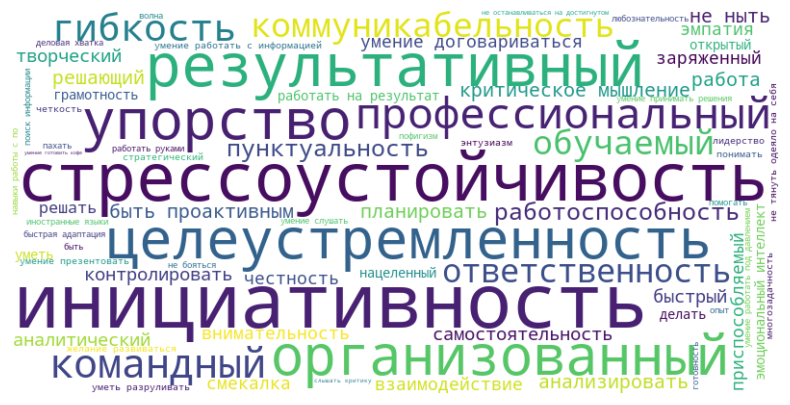

In [16]:
def generate_word_cloud(word_dict):
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate_from_frequencies(word_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

generate_word_cloud(final_word_dict)

### Гистограмма распределения слов

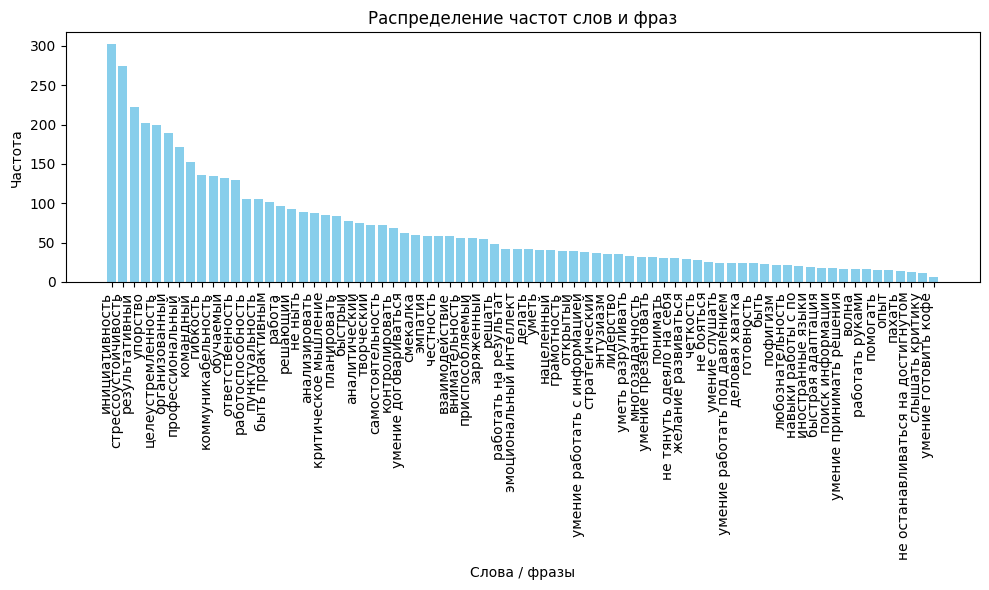

In [17]:
def plot_word_histogram(word_dict: dict) -> None:
    sorted_word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1], reverse=True))
    
    words = list(sorted_word_dict.keys())
    frequencies = list(sorted_word_dict.values())

    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color='skyblue')
    plt.ylabel('Частота')
    plt.xlabel('Слова / фразы')
    plt.title('Распределение частот слов и фраз')
    plt.xticks(rotation=90, ha='right')  # Поворачиваем метки на оси X для удобства
    plt.tight_layout()
    plt.show()
    
plot_word_histogram(final_word_dict)